In [1]:
import numpy as np
import rasterio as rio
from pathlib import Path
from rasterio.features import sieve
from matplotlib import pyplot as plt
import fiona
from rasterio.mask import mask as rio_mask

In [2]:
img_path = Path(r"C:\Users\Sumana\Pixxel\tile1_avg11.tiff")
img_d = Path("clipped_int5.tif")
img_m = Path("clipped_avg11.tif")
shp_path = Path(r"D:\pixxel\roi\ref.shp")

In [3]:
with rio.open(img_path, 'r') as src:
    meta = src.meta.copy()
    meta['dtype'] = np.int32
    with rio.open(img_d, 'w', **meta) as dst:
        dst.write(src.read().astype(np.int32))

In [4]:
def generate_masked_image(imgfile, out_img=None, current_nd=0, target_nd=-1, size=500):
    with rio.open(imgfile, 'r') as src:
        meta = src.meta.copy()
        img_array = src.read(masked=False)
        mask = img_array == current_nd
        mask =  mask.all(axis=0)
        # plt.imshow(mask)
        # plt.show()
        # mask = np.stack((mask for i in range(img_array.shape[0])), axis=0)
        mask =  np.iinfo(np.uint8).max * ((np.logical_not(mask)).astype(np.uint8))
        mask = sieve(mask, size=size)
        
        mask = np.logical_not(mask.astype(bool))
        mask = np.stack([mask for i in range(img_array.shape[0])], axis=0)
        img_array[mask] = target_nd
        meta['nodata'] = target_nd
    if out_img is None:
        out_img = imgfile
    with rio.open(out_img, 'w', **meta) as dst:
        dst.write(img_array)

In [5]:
generate_masked_image(img_d, img_m, 0, -1, 500)

In [6]:
def extract_pixels(imgfile, shapefile, attributes=None, all_touched=True):
    lbl_flag = False
    with fiona.open(shapefile) as shp_fp:
        with rio.open(imgfile, 'r') as img_fp:
            feature_vectors, label_vectors = list(), list()
            for feature in shp_fp:
                if feature["geometry"]['type'] in ("MultiPolygon", "Polygon"):
                    masked_box, _ = rio_mask(
                        dataset=img_fp,
                        shapes=[feature["geometry"],],
                        all_touched=all_touched,
                        crop=True,
                        filled=False,
                        pad=False
                    )
                    # im = np.moveaxis(masked_box[:3], 0, -1)
                    # im = im / np.nanmax(im)
                    # plt.imshow(im)
                    # plt.show()
                    # RasterIO Reads Bands First
                    bandwise_pixeldump = list()
                    for i in range(masked_box.shape[0]):
                        assert (
                            masked_box[0].mask == masked_box[i].mask
                        ).all(), "Band-wise Mask Mismatch! <Band {}>".format(i)
                        bandwise_pixeldump.append(masked_box[i].compressed())
                    pixel_dump = np.stack(bandwise_pixeldump, axis=-1)
                    if attributes and isinstance(attributes, (str, tuple, list)):
                        if isinstance(attributes, str):
                            attributes = (attributes,)
                        bandwise_labeldump = list()
                        for attr in attributes:
                            assert attr in shp_fp.schema[
                                'properties'
                            ].keys(), "Provided Attribute({}) not found in data!".format(
                                attr
                            )
                            lbl_flag = True
                            fill_val = feature['properties'][attr]
                            if np.issubdtype(type(fill_val), np.number):
                                proxy_array = np.full_like(
                                    bandwise_pixeldump[-1],
                                    fill_val
                                )
                            else:
                                proxy_array = np.full_like(
                                    bandwise_pixeldump[-1],
                                    fill_val,
                                    dtype=object
                                )
                            bandwise_labeldump.append(proxy_array)
                        label_dump = np.stack(bandwise_labeldump, axis=-1)
                        label_vectors.append(label_dump)
                    feature_vectors.append(pixel_dump)
            if len(feature_vectors) > 0:
                feature_vectors = np.concatenate(feature_vectors, axis=0)
            else:
                feature_vectors = np.array([])
            if len(label_vectors) > 0:
                assert len(label_vectors) == len(label_vectors), "Label Vector Count and Feature Vector Count Mismatch!"
                label_vectors = np.concatenate(label_vectors, axis=0)
            else:
                label_vectors =  np.array([])
            if lbl_flag:
                return feature_vectors, label_vectors
            else:
                return feature_vectors

In [7]:
x,y = extract_pixels(img_m, shp_path,'CLASS_ID', True)

In [8]:
x.shape, y.shape

((58740, 14), (58740, 1))

In [9]:
import sklearn
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,shuffle= True)

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10,random_state=0)
rf.fit(x_train, y_train)

D:\anaconda\envs\sumo\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [11]:
y_pred1 = rf.predict(x_test)

In [12]:
from sklearn import metrics
print("Accuracy of prediction by model is:",
metrics.accuracy_score(y_test, y_pred1)*100)

Accuracy of prediction by model is: 97.36692770400636


In [13]:
y_prob = rf.predict_proba(x_test)

In [14]:
maxm = np.amax(y_prob, axis=-1)
y_pred= 1+np.argmax(y_prob, axis=-1)
y_pred[maxm < 0.6] = 0

In [15]:
y_test = y_test.astype(np.int64)

In [16]:
from sklearn import metrics
print("Accuracy of the prediction using probabilty matrix is:",
metrics.accuracy_score(y_test, y_pred)*100)

Accuracy of the prediction using probabilty matrix is: 96.94699807059357


In [17]:
o_meta = None
msk = None
im_shape = None
with rio.open(r'C:\Users\Sumana\Pixxel\clipped_avg11.tif') as src:
    f_vec = list()
    o_meta = src.meta.copy()
    m_list = list()
    im_shape = meta['count'], meta['height'], meta['width']
    for i in range(src.count):
        b = src.read(i+1, masked=True)
        bpixels = b.compressed()
        f_vec.append(bpixels)
        m_list.append(b.mask)
    assert all(np.all(m == m_list[0]) for m in m_list)
    im_dat = np.stack(f_vec, axis=-1)
    msk = m_list[0]

In [18]:
img1_prob = rf.predict_proba(im_dat)

In [19]:
max_p = np.amax(img1_prob, axis=-1)
pred_labels = np.argmax(img1_prob, axis=-1)
pred_labels[max_p < 0.6] = -1

In [37]:
img_pred = np.zeros(im_shape[1:], dtype=np.int32)
img_pred = np.ma.masked_array(img_pred, mask=msk, fill_value=-1)
img_pred[np.logical_not(msk)] = pred_labels
img_pred = img_pred.filled()
img_pred = np.stack((img_pred,), axis=0)

In [38]:
img_pred.shape

(1, 3481, 1021)

In [39]:
o_meta['count'] = 1
o_meta['dtype'] = np.int32
o_meta['nodata'] = -1
with rio.open("classified_avg11.tif", 'w', **o_meta) as dst:
    dst.write(img_pred)

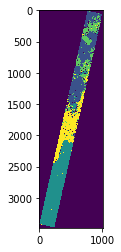

In [40]:
plt.imshow(img_pred[0])

In [41]:
img_pred.shape

(1, 3481, 1021)

In [42]:
predicted = img_pred[0,:,:]
predicted.shape

(3481, 1021)

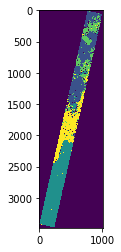

In [43]:
plt.imshow(predicted)

In [44]:
veg = []
water = []
#Classification of various features based on NDVI values
for i in range(predicted.shape[0]):
    for j in range(predicted.shape[1]):
        if (predicted[i,j] == 0):
            veg.append(predicted[i,j])
            predicted[i,j] = 1
        elif (predicted[i,j] == 1):
            water.append(predicted[i,j])
            predicted[i,j]=2
         
            
        else:
            predicted[i,j]=0

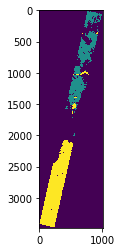

In [45]:
plt.imshow(predicted)

In [46]:
from osgeo import gdal
i = gdal.Open(r'D:\pixxel\EO1H1480472016328110PZ_1GST\ndvi\ndvi_tr.tiff.tif')
ndvi = i.ReadAsArray()

In [47]:
ndvi.shape

(3481, 1021)

In [48]:
veg1 = []
water1 = []
#Classification of various features based on NDVI values
for i in range(ndvi.shape[0]):
    for j in range(ndvi.shape[1]):
        if (ndvi[i,j] > 0.2):
            veg1.append(ndvi[i,j])
            ndvi[i,j] = 1           

        elif (ndvi[i,j]>(-1) and ndvi[i,j]< (-0.1)):
            water1.append(ndvi[i,j])
            ndvi[i,j]=2
            
        else:
            ndvi[i,j]=0

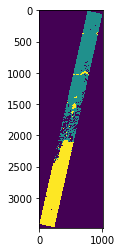

In [49]:
plt.imshow(ndvi)

In [50]:
ndvi= ndvi.astype(np.int32)
ndvi

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [51]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ndvi.ravel(), predicted.ravel())

In [52]:
cm

array([[2779755,      62,    1022],
       [ 218723,  221509,      32],
       [   7059,      10,  325929]], dtype=int64)

In [53]:
print('Percentage of Vegetation correctly classified', (cm[1,1]/(cm[1,0]+cm[1,1]+cm[1,2])*100))
print('Percentage of Water correctly classified', (cm[2,2]/(cm[2,0]+cm[2,2]+cm[2,1])*100))

Percentage of Vegetation correctly classified 50.312766885323356
Percentage of Water correctly classified 97.87716442741397
